**Skin Lesion Classification on segmented images(re-weighting) using EfficientNet**

**Loading files from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Importing the required libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB2
import cv2  
from google.colab.patches import cv2_imshow

In [ ]:
import pathlib
root_path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Segmented_train_120epochs"
data_dir = pathlib.Path(root_path)

**Splitting the data into training and validation**

In [ ]:
batch_size=64

In [ ]:
img_height,img_width=256,256
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25331 files belonging to 8 classes.
Using 20265 files for training.


In [ ]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25331 files belonging to 8 classes.
Using 5066 files for validation.


**Re-weighting technique**

In [ ]:
y_true = []
with open("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/y_train.txt", mode="r") as outfile:
  for line in outfile:
    sam = line[:-1]
    y_true.append(sam)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_true),
                                        y = y_true                                                    
                                    )
class_weights = dict(zip(np.unique(y_true), class_weights))
class_weights

{'AK': 3.5231223922114046,
 'BCC': 0.9508727477477478,
 'BKL': 1.2033847980997625,
 'DF': 12.990384615384615,
 'MEL': 0.6987931034482758,
 'NV': 0.24715825934237487,
 'SCC': 4.957191780821918,
 'VASC': 12.858502538071066}

In [ ]:
new_dict = {0: 3.5231223922114046, 1: 0.9508727477477478, 2: 1.2033847980997625, 3: 12.990384615384615, 4: 0.6987931034482758, 5: 0.24715825934237487, 6: 4.957191780821918, 7: 12.858502538071066}


**Visualizing the data**

In [ ]:
import cv2  
from google.colab.patches import cv2_imshow

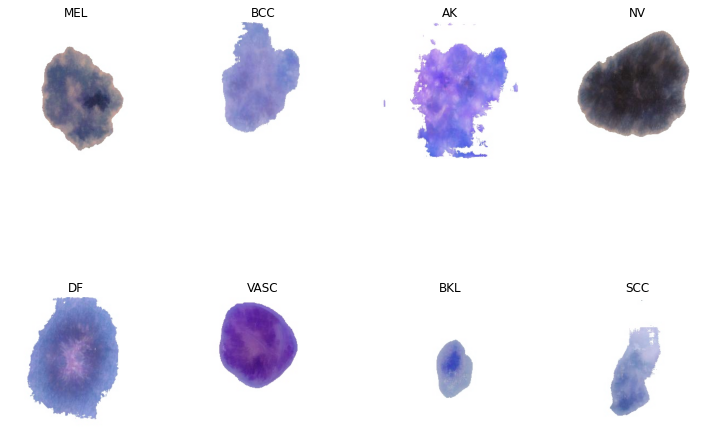

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,4,figsize=[10,10])

ax[0, 0].title.set_text('MEL')
ax[0, 1].title.set_text('BCC')
ax[0, 2].title.set_text('AK')
ax[0, 3].title.set_text('NV')

img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Segmented_train_120epochs/MEL/ISIC_0000002.jpg')
ax[0, 0].imshow(img)
ax[0, 0].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Segmented_train_120epochs/BCC/ISIC_0024331.jpg')
ax[0, 1].imshow(img)
ax[0, 1].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Segmented_train_120epochs/AK/ISIC_0024468.jpg')
ax[0, 2].imshow(img)
ax[0, 2].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Segmented_train_120epochs/NV/ISIC_0000000.jpg')
ax[0, 3].imshow(img)
ax[0, 3].axis("off")

ax[1, 0].title.set_text('DF')
ax[1, 1].title.set_text('VASC')
ax[1, 2].title.set_text('BKL')
ax[1, 3].title.set_text('SCC')


img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Segmented_train_120epochs/DF/ISIC_0024318.jpg')
ax[1, 0].imshow(img)
ax[1, 0].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Segmented_train_120epochs/VASC/ISIC_0024370.jpg')
ax[1, 1].imshow(img)
ax[1, 1].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Segmented_train_120epochs/BKL/ISIC_0012103_downsampled.jpg')
ax[1, 2].imshow(img)
ax[1, 2].axis("off")
img = cv2.imread('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/Segmented_train_120epochs/SCC/ISIC_0024329.jpg')
ax[1, 3].imshow(img)
ax[1, 3].axis("off")

fig.tight_layout(h_pad=-4, w_pad=5)


**Training the model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
inputs = layers.Input(shape=(256, 256, 3))
x = img_augmentation(inputs)  
model = EfficientNetB2(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
#model.trainable = False

# take a tensor and compute the average value of all values across the entire matrix for each of the input channels.
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
# 
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(8, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

31801344/31790344 [==============================] - 1s 0us/step


In [ ]:
# 20 epochs

epochs=20
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, class_weight = new_dict)

Epoch 1/20
317/317 [==============================] - 959s 3s/step - loss: 1.6600 - accuracy: 0.3775 - val_loss: 1.7450 - val_accuracy: 0.4049
Epoch 2/20
317/317 [==============================] - 274s 861ms/step - loss: 1.3843 - accuracy: 0.4427 - val_loss: 1.4294 - val_accuracy: 0.4878
Epoch 3/20
317/317 [==============================] - 274s 863ms/step - loss: 1.2054 - accuracy: 0.5090 - val_loss: 1.4243 - val_accuracy: 0.4923
Epoch 4/20
317/317 [==============================] - 274s 863ms/step - loss: 1.1297 - accuracy: 0.5334 - val_loss: 1.3161 - val_accuracy: 0.5215
Epoch 5/20
317/317 [==============================] - 274s 863ms/step - loss: 1.0337 - accuracy: 0.5606 - val_loss: 1.2600 - val_accuracy: 0.5324
Epoch 6/20
317/317 [==============================] - 275s 864ms/step - loss: 0.9769 - accuracy: 0.5821 - val_loss: 1.1317 - val_accuracy: 0.5819
Epoch 7/20
317/317 [==============================] - 274s 863ms/step - loss: 0.9131 - accuracy: 0.5983 - val_loss: 1.1290 - va

In [ ]:
model.save('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/20_Processed_Segmented_Bal_efficientnet_model.h5')
print("EfficientNet Model saved")

EfficientNet Model saved


In [ ]:
#40 epochs

model.trainable = True
epochs=20
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, class_weight = new_dict)

Epoch 1/20
317/317 [==============================] - 305s 880ms/step - loss: 0.3142 - accuracy: 0.8018 - val_loss: 0.8833 - val_accuracy: 0.7086
Epoch 2/20
317/317 [==============================] - 278s 873ms/step - loss: 0.2924 - accuracy: 0.8111 - val_loss: 0.8837 - val_accuracy: 0.7159
Epoch 3/20
317/317 [==============================] - 276s 870ms/step - loss: 0.2873 - accuracy: 0.8141 - val_loss: 0.8855 - val_accuracy: 0.7148
Epoch 4/20
317/317 [==============================] - 277s 871ms/step - loss: 0.2761 - accuracy: 0.8177 - val_loss: 0.8800 - val_accuracy: 0.7189
Epoch 5/20
317/317 [==============================] - 277s 872ms/step - loss: 0.2705 - accuracy: 0.8197 - val_loss: 0.8986 - val_accuracy: 0.7114
Epoch 6/20
317/317 [==============================] - 277s 872ms/step - loss: 0.2701 - accuracy: 0.8249 - val_loss: 0.8907 - val_accuracy: 0.7171
Epoch 7/20
317/317 [==============================] - 277s 873ms/step - loss: 0.2593 - accuracy: 0.8284 - val_loss: 0.8863 -

In [ ]:
model.save('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/40_Processed_Segmented_Bal_efficientnet_model.h5')
print("EfficientNet Model saved")

EfficientNet Model saved


In [ ]:
#50 epochs

epochs=10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, class_weight = new_dict)

Epoch 1/10
317/317 [==============================] - 298s 878ms/step - loss: 0.1712 - accuracy: 0.8752 - val_loss: 0.9153 - val_accuracy: 0.7385
Epoch 2/10
317/317 [==============================] - 275s 866ms/step - loss: 0.1693 - accuracy: 0.8746 - val_loss: 0.8966 - val_accuracy: 0.7422
Epoch 3/10
317/317 [==============================] - 275s 866ms/step - loss: 0.1627 - accuracy: 0.8787 - val_loss: 0.9033 - val_accuracy: 0.7390
Epoch 4/10
317/317 [==============================] - 275s 865ms/step - loss: 0.1570 - accuracy: 0.8846 - val_loss: 0.9055 - val_accuracy: 0.7426
Epoch 5/10
317/317 [==============================] - 275s 866ms/step - loss: 0.1573 - accuracy: 0.8886 - val_loss: 0.9085 - val_accuracy: 0.7412
Epoch 6/10
317/317 [==============================] - 275s 866ms/step - loss: 0.1637 - accuracy: 0.8816 - val_loss: 0.9207 - val_accuracy: 0.7418
Epoch 7/10
317/317 [==============================] - 275s 864ms/step - loss: 0.1592 - accuracy: 0.8824 - val_loss: 0.9109 -

In [ ]:
model.save('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/50_Processed_Segmented_Bal_efficientnet_model.h5')
print("EfficientNet Model saved")

EfficientNet Model saved


**Validation Testing**

In [ ]:
from keras.models import load_model
model=load_model('/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/Classification/50_Processed_Segmented_Bal_efficientnet_model.h5')

In [ ]:
y_val = np.zeros(5066, dtype=object)
x_val = np.zeros([5066, 256, 256, 3])
i=0
j=0

In [ ]:
for x,y in val_ds:
  for k in x:
    x_val[j, :,:] = k
    j+=1
  for p in y:
    y_val[i] = p
    i+=1

In [ ]:
y_label = np.empty(5066, dtype=object)
for i in range(len(y_val)):
  y_label[i] = np.array(y_val[i])

In [ ]:
classnames = train_ds.class_names
classnames

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

In [ ]:
pred=model.predict(x_val,batch_size=64, verbose=1)

80/80 [==============================] - 62s 753ms/step


In [ ]:
y_true=[]
for i in range(len(y_label)):
  y_true.append(classnames[y_label[i]])

In [ ]:
output_class=[]
for i in range(len(pred)):
  output_class.append(classnames[np.argmax(pred[i])])

**Displaying few predicted samples**

In [ ]:
for i in range(50):
  print("\nImage : ", i+1)
  cv2_imshow(x_val[i])
  print("The actual class is", y_true[i])
  print("The predicted class is", output_class[i]) 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Crct_Counter={'AK':0,'MEL':0,'BCC':0,'NV':0,'BKL':0,'DF':0,'VASC':0,'SCC':0}
Total_Counter={'AK':0,'MEL':0,'BCC':0,'NV':0,'BKL':0,'DF':0,'VASC':0,'SCC':0}
for i in range(len(pred)):
  Total_Counter[y_true[i]]+=1
  if(y_true[i]==output_class[i]):
    Crct_Counter[y_true[i]]+=1

**Accuracies for each class**

In [ ]:
print("Class_name \t\t Crct_pred \t\t  tot_images \t\t Accuracy")
print("AK\t\t\t",Crct_Counter['AK'],"\t\t\t ",Total_Counter['AK'],"\t\t\t",round(Crct_Counter['AK']/Total_Counter['AK'],2))
print("MEL\t\t\t",Crct_Counter['MEL'],"\t\t\t ",Total_Counter['MEL'],"\t\t\t",round(Crct_Counter['MEL']/Total_Counter['MEL'],2))
print("BCC\t\t\t",Crct_Counter['BCC'],"\t\t\t ",Total_Counter['BCC'],"\t\t\t",round(Crct_Counter['BCC']/Total_Counter['BCC'],2))
print("NV\t\t\t",Crct_Counter['NV'],"\t\t\t ",Total_Counter['NV'],"\t\t\t",round(Crct_Counter['NV']/Total_Counter['NV'],2))
print("BKL\t\t\t",Crct_Counter['BKL'],"\t\t\t ",Total_Counter['BKL'],"\t\t\t",round(Crct_Counter['BKL']/Total_Counter['BKL'],2))
print("DF\t\t\t",Crct_Counter['DF'],"\t\t\t ",Total_Counter['DF'],"\t\t\t",round(Crct_Counter['DF']/Total_Counter['DF'],2))
print("VASC\t\t\t",Crct_Counter['VASC'],"\t\t\t ",Total_Counter['VASC'],"\t\t\t",round(Crct_Counter['VASC']/Total_Counter['VASC'],2))
print("SCC\t\t\t",Crct_Counter['SCC'],"\t\t\t ",Total_Counter['SCC'],"\t\t\t",round(Crct_Counter['SCC']/Total_Counter['SCC'],2))


Class_name 		 Crct_pred 		  tot_images 		 Accuracy
AK			 75 			  148 			 0.51
MEL			 615 			  897 			 0.69
BCC			 461 			  659 			 0.7
NV			 2138 			  2626 			 0.81
BKL			 331 			  519 			 0.64
DF			 25 			  44 			 0.57
VASC			 46 			  56 			 0.82
SCC			 73 			  117 			 0.62


**Displaying the classification report**

In [ ]:
from sklearn.metrics import classification_report
target_names = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
print(classification_report(y_true, output_class, target_names=target_names))

              precision    recall  f1-score   support

          AK       0.41      0.51      0.45       148
         BCC       0.73      0.70      0.71       659
         BKL       0.53      0.64      0.58       519
          DF       0.81      0.57      0.67        44
         MEL       0.63      0.69      0.65       897
          NV       0.89      0.81      0.85      2626
         SCC       0.52      0.62      0.57       117
        VASC       0.71      0.82      0.76        56

    accuracy                           0.74      5066
   macro avg       0.65      0.67      0.66      5066
weighted avg       0.76      0.74      0.75      5066



**Displaying the Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, output_class, labels=target_names)

array([[  75,   26,   21,    0,   13,    2,   11,    0],
       [  43,  461,   40,    2,   49,   34,   25,    5],
       [  25,   21,  331,    0,   59,   68,   12,    3],
       [   2,    4,    6,   25,    0,    3,    4,    0],
       [  16,   32,   61,    0,  615,  159,    6,    8],
       [  14,   65,  158,    4,  235, 2138,    9,    3],
       [   6,   16,   12,    0,    8,    2,   73,    0],
       [   1,    7,    0,    0,    2,    0,    0,   46]])